# Batch effect correction (multiple batches)

Here we will use human pancreas datasets (scRNA-seq data) of different studies as an example to illustrate how Garfield performs scRNA-seq batch correction for multiple batches.

In [1]:
import os
import pandas as pd
import numpy as np

os.chdir('/data2/zhouwg_data/project/Garfield')
os.getcwd()

'/data2/zhouwg_data/project/Garfield'

In [2]:
# load packages
import os
import warnings
import Garfield as gf
import scanpy as sc
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

gf.__version__

'1.0.0'

In [3]:
## load data
adata = sc.read_h5ad('/home/zhouweige/zhouwg_data/project/Garfield_tutorials/data/panc8.h5ad')
adata

AnnData object with n_obs × n_vars = 14890 × 34363
    obs: 'ClusterID', 'ClusterName', 'batch', 'celltype', 'nCount_RNA'
    var: 'Selected', 'vst_mean', 'vst_variable', 'vst_variance', 'vst_variance_expected', 'vst_variance_standardized'
    obsm: 'pca_cell_embeddings', 'umap_cell_embeddings'
    varm: 'pca_feature_loadings'
    layers: 'counts', 'norm_data', 'scale_data'

In [4]:
# Ensure adata.X is counts.
adata.X.max()

1453667.0

In [5]:
# check the batch information of this dataset
adata.obs['batch'].value_counts()

batch
indrop        8569
smartseq2     2394
celseq2       2285
celseq        1004
fluidigmc1     638
Name: count, dtype: int64

### Perform batch effect correction using Garfield

For batch effect correction from scRNAseq data, we should adjust the following paremeters,
and all parameter introductions can be found in [Garfield_Model_Parameters](https://github.com/zhou-1314/Garfield/blob/main/Garfield_Model_Parameters.md).

In [6]:
# set workdir
workdir = '/home/zhouweige/zhouwg_data/project/Garfield_tutorials/result/garfield_scRNA_panc' 
gf.settings.set_workdir(workdir)

### modify parameter
user_config = dict(
    ## Input options
    adata_list=adata, 
    profile='RNA',   # if it is 'ATAC' or 'ADT', please adjust it.
    sample_col='batch',  # Specify columns for batch information.
    ## Preprocessing options
    used_hvg=True,
    min_cells=3,
    min_features=0,
    keep_mt=False,
    target_sum=1e4,
    rna_n_top_features=3000,
    atac_n_top_features=None, # if data belongs to 'ATAC', please specify it.
    n_components=50,
    n_neighbors=5,
    metric='euclidean',  # STR     Metric for clustering.                   Default is `euclidean`.
    svd_solver='arpack',
    # datasets
    used_pca_feat=False,
    adj_key='connectivities',
    # data split parameters
    edge_val_ratio=0.1,
    edge_test_ratio=0.,
    node_val_ratio=0.1,
    node_test_ratio=0.,
    ## Model options
    augment_type='svd',
    svd_q=5,
    use_FCencoder=False,
    conv_type='GATv2Conv', # GAT or GATv2Conv or GCN
    gnn_layer=2,
    hidden_dims=[128, 128],
    bottle_neck_neurons=20,
    cluster_num=20,
    drop_feature_rate=0.2, 
    drop_edge_rate=0.2,
    num_heads=3,
    dropout=0.2,
    concat=True,
    used_edge_weight=False,
    used_DSBN=False,
    used_mmd=True,
    # data loader parameters
    num_neighbors=5,
    loaders_n_hops=2,
    edge_batch_size=4096,
    node_batch_size=256, # None
    # loss parameters
    include_edge_recon_loss=False,
    include_gene_expr_recon_loss=True,
    lambda_latent_contrastive_instanceloss=1.0,
    lambda_latent_contrastive_clusterloss=0.5,
    lambda_gene_expr_recon=10., # To make the model more focused on learning expression features, increase this parameter.
    lambda_edge_recon=1., # To make the model more focused on learning Adjacency graph features, increase this parameter.
    lambda_latent_adj_recon_loss=1.0,
    lambda_omics_recon_mmd_loss=5.0, # If the integration is not strong enough, increase it.
    # train parameters
    n_epochs_no_edge_recon=0,
    learning_rate=0.001,
    weight_decay=1e-05,
    gradient_clipping=5,
    # other parameters
    latent_key='garfield_latent',
    reload_best_model=True,
    use_early_stopping=True,
    early_stopping_kwargs=None,
    monitor=True,
    seed=42,
    device_id=1, # GPU device id, default is 0.
    verbose=True
)
dict_config = gf.settings.set_gf_params(user_config)

Saving results in: /home/zhouweige/zhouwg_data/project/Garfield_tutorials/result/garfield_scRNA_panc


In [7]:
from Garfield.model import Garfield

# Initialize model
model = Garfield(dict_config)

--- DATA LOADING AND PREPROCESSING ---


/home/zhouweige/anaconda3/envs/Garfield/lib/python3.9/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


COSINE SIM GRAPH DECODER -> dropout_rate: 0.2


In [8]:
# Train model
model.train()


--- INITIALIZING TRAINER ---
Using GPU: device-1
Number of training nodes: 13401
Number of validation nodes: 1489
Number of training edges: 41925
Number of validation edges: 4658
Edge batch size: 4096
Node batch size: 256

--- MODEL TRAINING ---
Epoch 1/100 |--------------------| 1.0% val_auroc_score: 0.9093; val_auprc_score: 0.8986; val_best_acc_score: 0.8243; val_best_f1_score: 0.8329; train_kl_reg_loss: 8.7155; train_edge_recon_loss: 1065.0080; train_gene_expr_recon_loss: 44671.5746; train_lambda_latent_adj_recon_loss: 440.3092; train_lambda_latent_contrastive_instanceloss: 7.8564; train_lambda_latent_contrastive_clusterloss: 3.7105; train_gene_expr_mmd_loss: 14061.0143; train_global_loss: 59193.1797; train_optim_loss: 59193.1797; val_kl_reg_loss: 5.3916; val_edge_recon_loss: 688.0709; val_gene_expr_recon_loss: 37423.5762; val_lambda_latent_adj_recon_loss: 173.0055; val_lambda_latent_contrastive_instanceloss: 7.6594; val_lambda_latent_contrastive_clusterloss: 3.7370; val_gene_expr_

In [9]:
# Compute latent neighbor graph
latent_key = 'garfield_latent'
sc.pp.neighbors(model.adata,
                use_rep=latent_key,
                key_added=latent_key)
# Compute UMAP embedding
sc.tl.umap(model.adata,
           neighbors_key=latent_key)

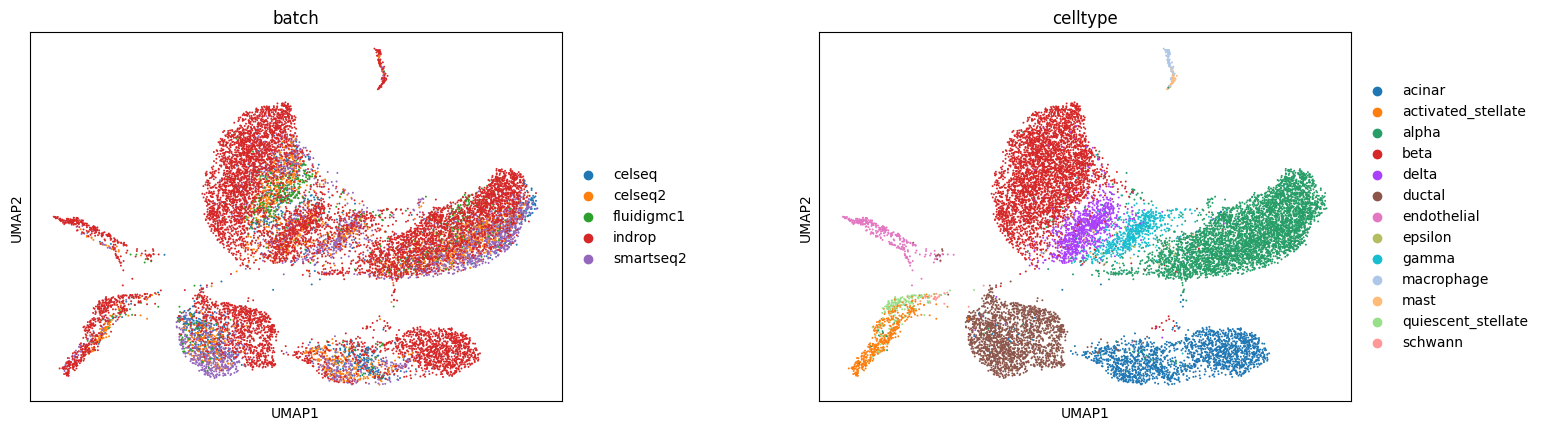

In [10]:
sc.pl.umap(model.adata, color=['batch', 'celltype'], wspace=0.35, edges=False)

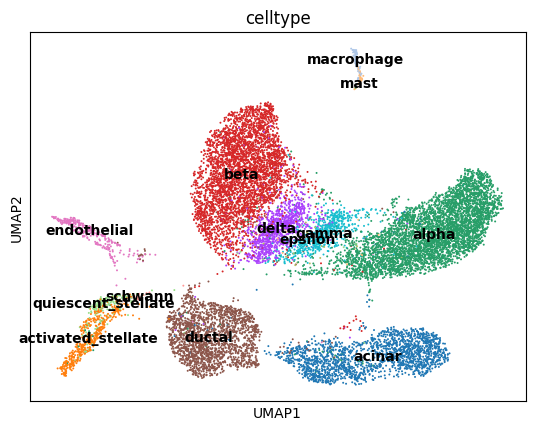

In [11]:
sc.pl.umap(model.adata, color=['celltype'], wspace=0.35, edges=False, legend_loc='on data')

In [12]:
# Save trained model
model_folder_path = f"{workdir}/model"
os.makedirs(model_folder_path, exist_ok=True)

model.save(dir_path=model_folder_path,
           overwrite=True,
           save_adata=True,
           adata_file_name="adata_ref.h5ad")

Model saved successfully using pickle at /home/zhouweige/zhouwg_data/project/Garfield_tutorials/result/garfield_scRNA_panc/model/attr.pkl


In [14]:
# load pre-trained model
model = Garfield.load(dir_path=model_folder_path,
                       adata_file_name="adata_ref.h5ad")
model

Model loaded successfully using pickle from /home/zhouweige/zhouwg_data/project/Garfield_tutorials/result/garfield_scRNA_panc/model/attr.pkl
AnnData object with n_obs × n_vars = 14890 × 3000
    obs: 'ClusterID', 'ClusterName', 'batch', 'celltype', 'nCount_RNA', 'n_genes'
    var: 'Selected', 'vst_mean', 'vst_variable', 'vst_variance', 'vst_variance_expected', 'vst_variance_standardized', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'batch_colors', 'celltype_colors', 'garfield_latent', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'feat', 'garfield_latent', 'pca_cell_embeddings', 'umap_cell_embeddings'
    varm: 'PCs', 'pca_feature_loadings'
    layers: 'counts', 'norm_data', 'scale_data'
    obsp: 'connectivities', 'distances', 'garfield_latent_connectivities', 'garfield_latent_distances'
--- DATA LOADING AND PREPROCESSING ---
COSINE SIM GRAPH DECOD

Garfield(
  (model): GNNModelVAE(
    (encoder): GATEncoder(
      (layers): ModuleList(
        (0): GATv2Conv(3000, 128, heads=3)
        (1): GATv2Conv(384, 128, heads=3)
      )
      (norm_layers): ModuleList(
        (0-1): 2 x BatchNorm1d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_mean): GATv2Conv(384, 20, heads=3)
      (conv_log_std): GATv2Conv(384, 20, heads=3)
    )
    (decoder): InnerProductDecoder()
    (instance_projector): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): LayerNorm((20,), eps=1e-05, elementwise_affine=False)
      (2): ReLU()
      (3): Linear(in_features=20, out_features=3000, bias=True)
    )
    (cluster_projector): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): LayerNorm((20,), eps=1e-05, elementwise_affine=False)
      (2): ReLU()
      (3): Linear(in_features=20, out_features=20, bias=True)
      (4): Softmax(dim=1)
    )
    (gra